In [ ]:
!pip install shap captum torchinfo
!pip install timm

In [19]:
import numpy as np 
import pandas as pd 
import os
import shap
import shutil
from  torchvision.datasets import ImageFolder 
import torch
import torchvision
from captum.attr import IntegratedGradients
from captum.attr import KernelShap
from torchvision import datasets
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
import timm
from timm.loss import LabelSmoothingCrossEntropy 
from captum.attr import Lime
from skimage import segmentation
from torchvision import transforms as T 

## Downloading Butterfly Dataset from Kaggle

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download gpiosenka/butterfly-images40-species
! unzip butterfly-images40-species.zip

In [4]:
butterflies = pd.read_csv("butterflies.csv")
class_dict = pd.read_csv("class_dict.csv")

## Preprocessing and dropping some classes

In [20]:
classes_to_remove = class_dict['class'][20:]
for bf in classes_to_remove:
  rem_train = '/content/train/'+bf
  rem_valid = '/content/valid/'+bf
  rem_test = '/content/test/'+bf

  shutil.rmtree(rem_train)
  shutil.rmtree(rem_valid)
  shutil.rmtree(rem_test)

In [21]:
butterflies = butterflies[~butterflies.labels.isin(classes_to_remove)]
class_dict = class_dict[~class_dict['class'].isin(classes_to_remove)]

In [22]:
butterflies

,filepaths,labels,data set
0,train/ADONIS/01.jpg,ADONIS,train
1,train/ADONIS/02.jpg,ADONIS,train
2,train/ADONIS/03.jpg,ADONIS,train
3,train/ADONIS/04.jpg,ADONIS,train
4,train/ADONIS/05.jpg,ADONIS,train
...,...,...,...
9755,valid/CLOUDED SULPHUR/1.jpg,CLOUDED SULPHUR,valid
9756,valid/CLOUDED SULPHUR/2.jpg,CLOUDED SULPHUR,valid
9757,valid/CLOUDED SULPHUR/3.jpg,CLOUDED SULPHUR,valid
9758,valid/CLOUDED SULPHUR/4.jpg,CLOUDED SULPHUR,valid


In [23]:
class_dict

,class_index,class,SCIENTIFIC NAME,height,width,scale by
0,0,ADONIS,Lysandra bellargus,150,150,1
1,1,AFRICAN GIANT SWALLOWTAIL,Papilio antimachus,150,150,1
2,2,AMERICAN SNOOT,Libytheana carinenta,150,150,1
3,3,AN 88,Diaethria anna,150,150,1
4,4,APPOLLO,Parnassius apollo,150,150,1
5,5,ATALA,Eumaeus atala,150,150,1
6,6,BANDED ORANGE HELICONIAN,Dryadula phaetusa,150,150,1
7,7,BANDED PEACOCK,Anartia fatima,150,150,1
8,8,BECKERS WHITE,Pontia beckerii,150,150,1
9,9,BLACK HAIRSTREAK,Satyrium pruni,150,150,1


In [24]:
butterflies.groupby(['data set']).count()

,filepaths,labels
data set,,
test,100,100
train,2488,2488
valid,100,100


## Loading Data

In [25]:
transform = T.Compose([
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406) , (0.229, 0.224, 0.225)), 
        ])

In [26]:
train_set = ImageFolder('train', transform = transform)
test_set = ImageFolder('test', transform = transform)
valid_set = ImageFolder('valid', transform = transform)

In [27]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=8,
                                           pin_memory=True,
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(dataset=valid_set,
                                           batch_size=8,
                                           pin_memory=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                           batch_size=8,
                                           pin_memory=True,
                                           num_workers=2)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Creating a ResNet34 model and training it

In [31]:
model = torchvision.models.resnet34(pretrained=True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 75)
)


criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.fc.parameters(), lr=0.001)

model = model.to(device)

for epoch in range(4):  

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


All the training has been made on GPU. However, on the last day when I wanted to improve my network, Google Colab stopped being helpful and it crushed and disallowed me to continue to work on GPU, so I had to switch to CPU. Because of that, the model above was created on CPU and it is not as efficient as it was before.

## Explanations

In [33]:
images, labels = next(iter(train_loader))

from captum.attr import visualization

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

def mask(image):
  return segmentation.slic(
    image.permute(1, 2, 0).mean(axis=2), 
    n_segments=100, 
    compactness=0.1, 
    start_label=0,
  )

preprocess = torchvision.transforms.Compose([
   torchvision.transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

## Original Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


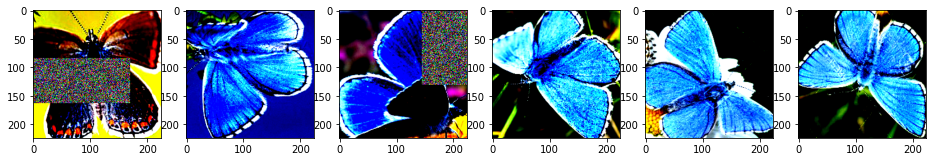

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=[16, 8])
for i in range(6):
  ax[i].imshow(images[i].permute(1, 2, 0))

## LIME explanation

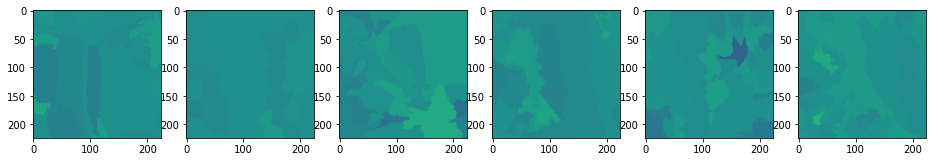

In [ ]:
explainer = Lime(model)

def attr(i):
  return explainer.attribute(
    preprocess(images[i].unsqueeze(0)), 
    target=labels[i], 
    n_samples=200, 
    feature_mask=torch.as_tensor(mask(images[i])),
    show_progress=False
  )

fig, ax = plt.subplots(1, 6, figsize=[16, 8])
for i in range(6):
  ax[i].imshow(attr(i)[0].mean(axis=0), vmin=-1, vmax=1)

## Integrated Gradients

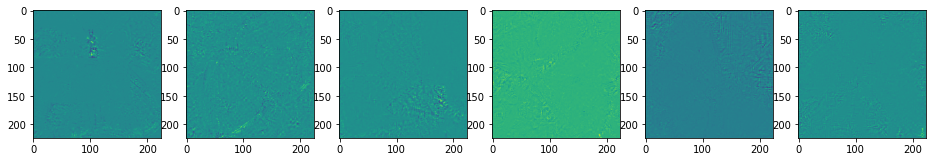

In [ ]:
exp_ig = IntegratedGradients(model)

def attr_ig(i):
   return exp_ig.attribute(
       preprocess(images[i].unsqueeze(0)), target=labels[i])
   
fig, ax = plt.subplots(1, 6, figsize=[16, 8])
for i in range(6): 
  ax[i].imshow(attr_ig(i)[0].mean(axis=0))

## SHAP explanation

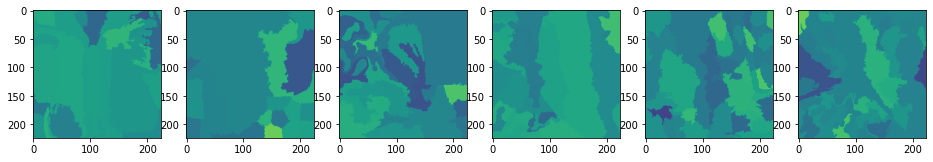

In [ ]:
exp_ks = KernelShap(model)

def attr_ks(i):
  return exp_ks.attribute(
    preprocess(images[i].unsqueeze(0)), 
    target=labels[i], 
    n_samples=200, 
    feature_mask=torch.as_tensor(mask(images[i])),
    show_progress=False
  )
fig, ax = plt.subplots(1, 6, figsize=[16, 8])
for i in range(6):
  ax[i].imshow(attr_ks(i)[0].mean(axis=0), vmin=-1, vmax=1)

## Conclusions

SHAP and LIME give the best explanations. They show both contours of an object and how important are the pixels "inside" an object. Integrated Gradients is not the best option to get an interpretation of a prediction, it displays mostly only the contours of an object.

## Analysis of misclassified photos (using SHAP explanation)

In [66]:
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                           batch_size=16,
                                           pin_memory=True,
                                           num_workers=2)

num= 0 
wrong = []
lab = []
pred = []
with torch.no_grad():
  for data in test_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      for i in range(len(predicted)):
        if predicted[i] != labels[i]:
          num+=1
          wrong.append(images[i])
          lab.append(labels[i])
          pred.append(predicted[i])
          if num==3:
            break
      
      if num==3:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


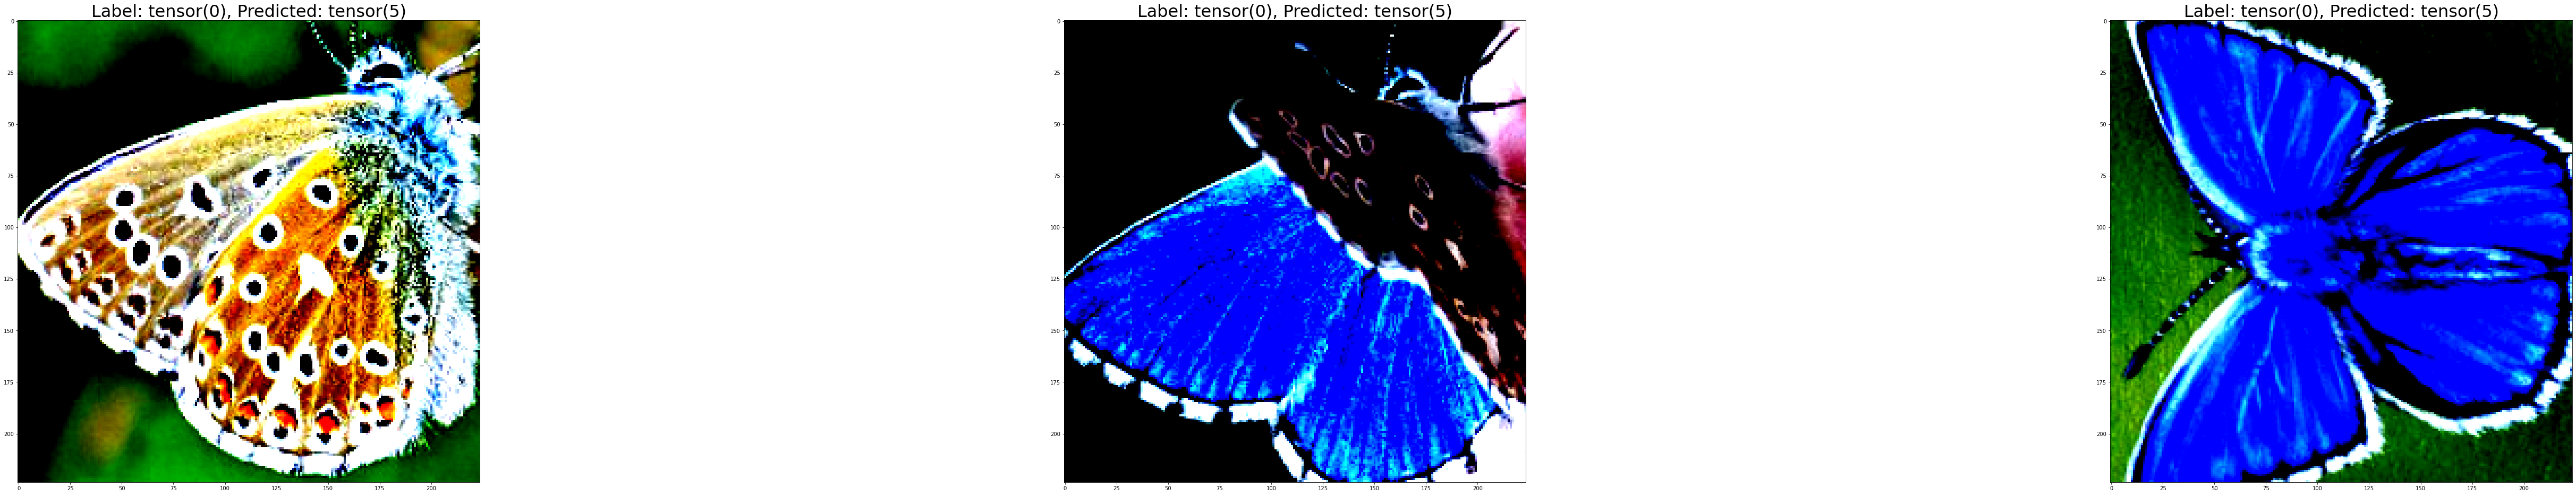

In [76]:
fig, ax = plt.subplots(1, 3, figsize=[100, 16])
for i in range(3):
  t= "Label: "+str(lab[i])+", Predicted: "+str(pred[i])
  ax[i].imshow(wrong[i].permute(2,1,0))
  ax[i].set_title(t, size=32)

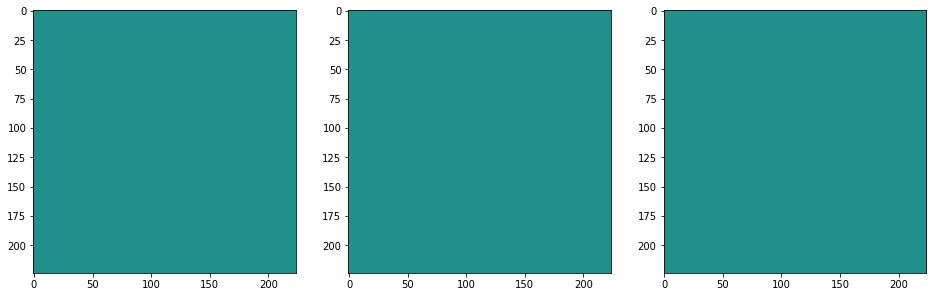

In [77]:
exp_ks = KernelShap(model)

def attr_ks(i):
  return exp_ks.attribute(
    preprocess(wrong[i].unsqueeze(0)), 
    target=lab[i], 
    n_samples=200, 
    feature_mask=torch.as_tensor(mask(wrong[i])),
    show_progress=False
  )
fig, ax = plt.subplots(1, 3, figsize=[16, 8])
for i in range(3):
  ax[i].imshow(attr_ks(i)[0].mean(axis=0), vmin=-1, vmax=1)

Due to the GPU usage limit, I had to perform this analysis on the badly trained model trained on CPU, which is why the SHAP explanation doesn't work as it was before.